# HSSM Advanced Tutorial

<center> <img src="./images/HSSM_logo.png"> </center>

Welcome to the HSSM Advanced Tutorial!

In this short tutorial we will explore some of the features of HSSM that are geared towards users who want to do one of two things:

1. Generally work with custom model that are not provided by HSSM out of the box (please consider contributing directly to the HSSM ecosystem eventually :))
2. Build custom PyMC models around observation models build via HSSM low-level utilities (to e.g. break out of the hierarchical regression corsett imposed via the [Bambi](https://bambinos.github.io/bambi/) interface)

## Colab Instructions

If you would like to run this tutorial on Google colab, please click this [link](https://githubtocolab.com/lnccbrown/HSSM/blob/carney-workshop-scientific-workflow/carney_workshop/hssm_advanced_1.ipynb). 

Once you are *in the colab*:

1. Follow the **installation instructions below**  (uncomment the respective code)
2.  **restart your runtime**. 

**NOTE**:

You may want to *switch your runtime* to have a GPU or TPU. To do so, go to *Runtime* > *Change runtime type* and select the desired hardware accelerator.
Note that if you switch your runtime you have to follow the installation instructions again.

In [1]:
# If running this on Colab, please uncomment the next line
# !pip install hssm
# !pip install onnxruntime
# !pip install "zeus-mcmc>=2.5.4"

In [2]:
# # Data Files
# !wget -P  data/carney_workshop_2025_data/ https://raw.githubusercontent.com/lnccbrown/HSSM/carney-workshop-scientific-workflow/carney_workshop/data/carney_workshop_2025_data/race_3_no_bias_lan_batch.onnx

## Start of Tutorial

### Load Modules

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import hssm
import arviz as az
import onnx
import onnxruntime as ort

## Creating a Blackbox Likelihood directly from an `onnx` file


<center> <img src="./images/onnx_logo.png"> </center>

HSSM allows us to work natively with with neural networks that are encoded as `.onnx` files.
We will see later that we provide even more sophisticated machinery, but here we first focus on loading an `.onnx` file into an `onnx runtime` and then wrapping that runtime into a `blackbox likelihood`, the most flexible type of likelihood we can construct.

The downside of this approach is that we loose access to gradients, the upside is that we are allowed to do literally whatever we want inside this likelihood function. See also here for a more generic [PyMC Tutorial](https://www.pymc.io/projects/examples/en/latest/howto/blackbox_external_likelihood_numpy.html) if you want to learn about how `blackbox` likelihoods work in [PyMC](https://www.pymc.io/welcome.html) directly.






### Defining the Network Path

In [4]:
# Networks
from pathlib import Path
network_path = Path("data", "carney_workshop_2025_data", "race_3_no_bias_lan_batch.onnx")

### Starting and Testing the onnx runtime


Below we load this `onnx` model. Think of it as an alternative format for saving and loading neural networks, that can serve as a translation layer between the basic neural network fromeworks such as [Pytorch](https://pytorch.org/), [TensorFlow](https://www.tensorflow.org/) and [JAX](https://docs.jax.dev/en/latest/quickstart.html), but can also used stand-alone package for fast computation with neural networks. 

We exploit the latter in this section, however HSSM internally focuses on the "translation-layer" concepts.

In [5]:
# Load onnx model
onnx_model = onnx.load(network_path)
input_name = onnx_model.graph.input[0].name
ort_session = ort.InferenceSession(onnx_model.SerializeToString())

# Test inference speed
import time

start = time.time()
for i in range(100):
    ort_session.run(
        None, {input_name: np.random.uniform(size=(1000, 8)).astype(np.float32)}
    )
end = time.time()
print(f"Time taken: {(end - start) / 100} seconds")

Time taken: 0.0005368804931640625 seconds


In [6]:
def my_blackbox_race_model(data, v0, v1, v2, a, t, z):
    """Calculate log-likelihood for a 3-choice race model.

    Parameters
    ----------
    data : np.ndarray
        Array of shape (n_trials, 2) containing response times in first column
        and choices (0, 1, or 2) in second column
    v0 : float
        Drift rate for accumulator 0
    v1 : float
        Drift rate for accumulator 1
    v2 : float
        Drift rate for accumulator 2
    a : float
        Decision threshold/boundary
    t : float
        Non-decision time
    z : float
        Starting point bias

    Returns
    -------
    np.ndarray
        Array of log-likelihood values for each trial
    """
    data_nrows = data.shape[0]
    data = np.vstack(
        [np.full(data_nrows, param_) for param_ in [v0, v1, v2, a, t, z]]
        + [data[:, 0], data[:, 1]]
    ).T.astype(np.float32)
    return ort_session.run(None, {input_name: data})[0].squeeze()

### Data and Underlying Model


This example focuses on a `Race` model with three choice options. See the picture below for an illustration:

<center> <img src="./images/Race_3.png"> </center>

In [7]:
# Set parameters
v0 = 1.0
v1 = 0.5
v2 = 0.25
a = 1.5
t = 0.3
z = 0.5

# simulate some data from the model
obs_race3 = hssm.simulate_data(
    theta=dict(v0=v0, v1=v1, v2=v2, a=a, t=t, z=z), model="race_no_bias_3", size=1000
)

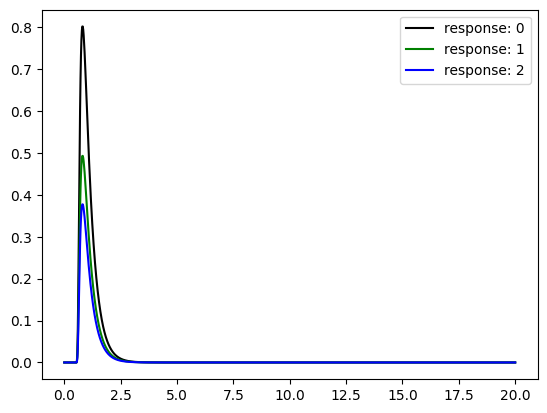

In [8]:
# Test that outputs are reasonable
colors = ["black", "green", "blue"]
for choice in [0, 1, 2]:
    rts = np.linspace(0, 20, 1000)
    choices = np.repeat(choice, 1000)

    data = np.vstack([rts, choices]).T
    out = my_blackbox_race_model(data, v0, v1, v2, a, t, z)

    plt.plot(rts, np.exp(out), 
             label=f"response: {choice}",
             color=colors[choice])
plt.legend()
plt.show()

### Construct HSSM Model

We can now construct our HSSM, using our custom likelihood very easily. We just need to supply a few extra arguments, so that HSSM has sufficient information to instantiate a complete model.

- Our likelihood is a "blackbox" function, so we set `log_lik_kind="blackbox"`
- We need to pass the core parameters and legal parameter bounds via the `model_config` argument
- We need to tell HSSM what legal responses are for the given model via the `choices` argument

The above arguments need to be set for any custom model.

Apart from that we set `z=0.5`, which is a choice informed by our experience fitting this 'Race' model, and we set `p_outlier=0` because we are dealing with synthetic data here.

In [9]:
model = hssm.HSSM(
    data=obs_race3,
    model="race_no_bias_3",  # some name for the model
    model_config={
        "list_params": ["v0", "v1", "v2", "a", "z", "t"],
        "bounds": {
            "v0": (0.0, 2.5),
            "v1": (0.0, 2.5),
            "v2": (0.0, 2.5),
            "a": (1.0, 3.0),
            "z": (0.0, 0.9),
            "t": (0.001, 2),
        },
    },  # minimal specification of model parameters and parameter bounds
    loglik_kind="blackbox",  # use the blackbox loglik
    loglik=my_blackbox_race_model,
    choices=[0, 1, 2],  # list the legal choice options
    z=0.5,
    p_outlier=0,
)

You have specified the `lapse` argument to include a lapse distribution, but `p_outlier` is set to either 0 or None. Your lapse distribution will be ignored.
Model initialized successfully.


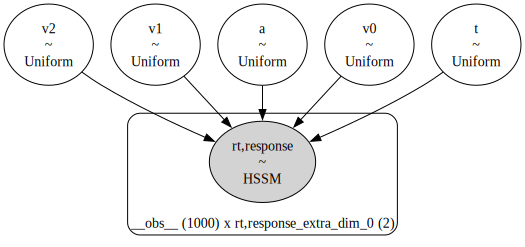

In [10]:
model.graph()

In [11]:
model.sample(draws=500,
             tune=200,
             discard_tuned_samples=False)

Using default initvals. 



Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [v2]
>Slice: [v1]
>Slice: [a]
>Slice: [t]
>Slice: [v0]


Output()

Sampling 4 chains for 200 tune and 500 draw iterations (800 + 2_000 draws total) took 31 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.11/site-packages/pymc/pytensorf.py:958: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(
100%|██████████| 2000/2000 [00:00<00:00, 2613.80it/s]


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

Warmup iterations saved (warmup_*).

/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.11/site-packages/arviz/utils.py:146: UserWarning: Items starting with ~: ['v0_mean'] have not been found and will be ignored
  warnings.warn(


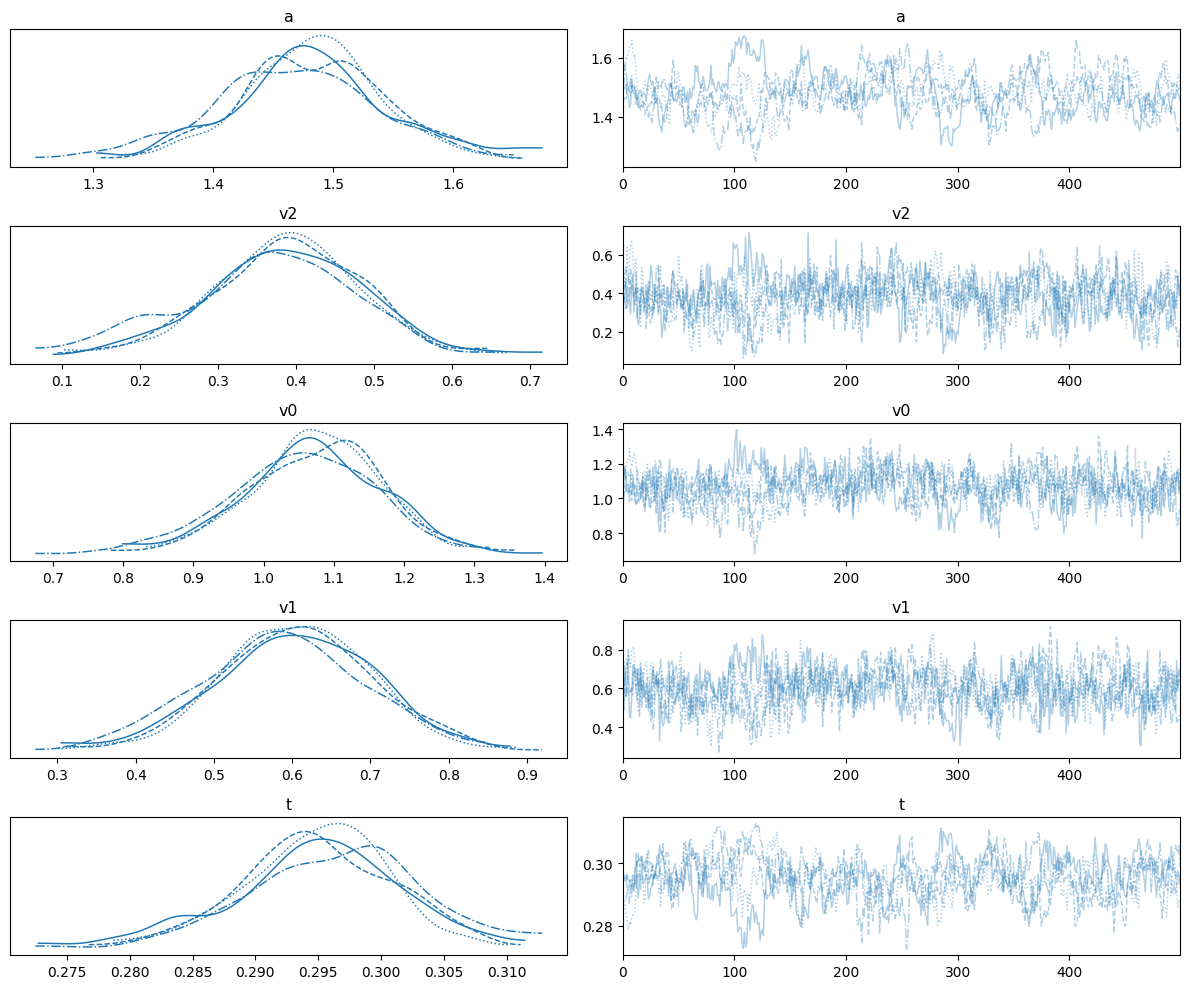

In [12]:
import arviz as az

az.plot_trace(model.traces, var_names=["~v0_mean"])
plt.tight_layout()

/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.11/site-packages/arviz/utils.py:146: UserWarning: Items starting with ~: ['v0_mean'] have not been found and will be ignored
  warnings.warn(


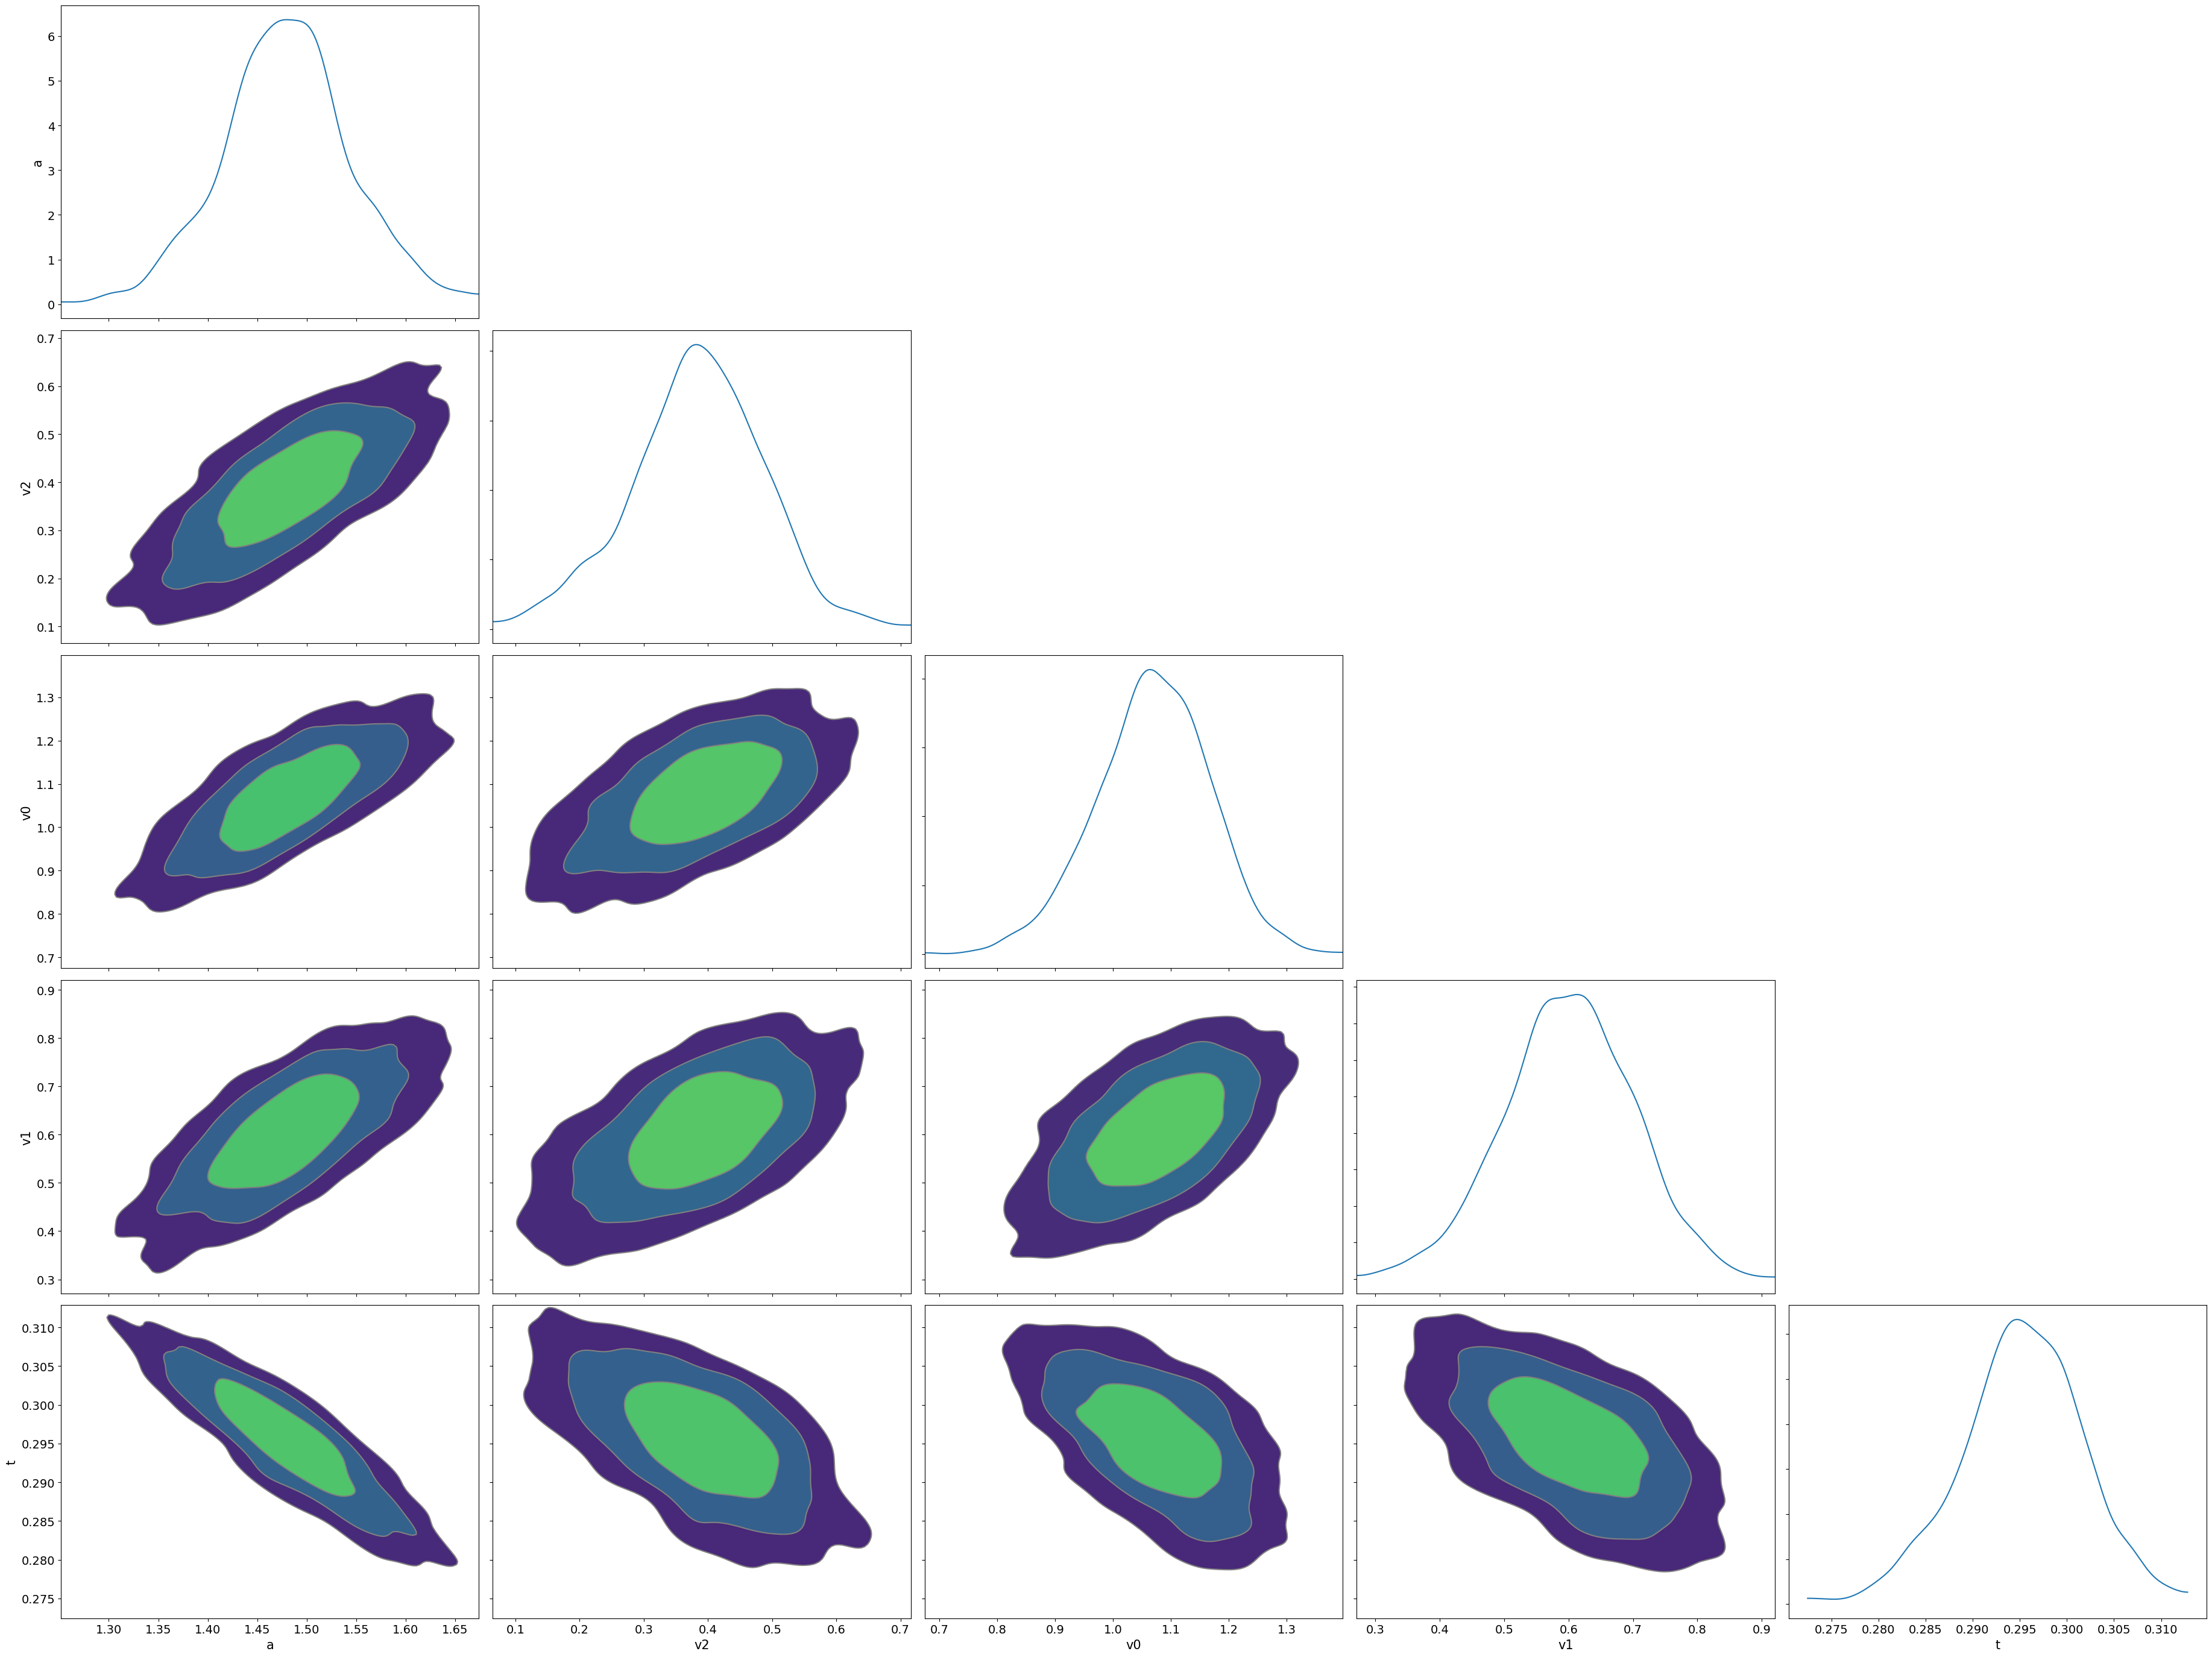

In [13]:
az.plot_pair(model.traces,
             var_names=["~v0_mean"],
             kind = "kde",
             marginals = True)
plt.tight_layout()

And voilà, we can do our standard analysis with this HSSM model based on a custom specifciation of our *Sequential Sampling Model*.

## It gets better


The *blackbox* idea is very general and allows us to test an unlimited amount of models. However, in some sense it is like fighting bare handed. We can do a lot better if we construct out likelihood (insofar it is a priori differentiable) so that we can make use of gradients.

Remember that the `.onnx` file is just a representation for a neural network... this Network is actually a [LAN](https://elifesciences.org/articles/65074), and hence, by definition differentiable with respect to it's inputs (the parameters of the model).


<center> <img src="./images/basic_lan_pic.png" height=300 width=600> </center>

HSSM is smart enough to be able to construct a valid wrapper around this so that we can use the network with gradients! Let's see how this works below.

In [14]:
better_model = hssm.HSSM(
    data=obs_race3,
    model="race_no_bias_3",  # some name for the model
    model_config={
        "list_params": ["v0", "v1", "v2", "a", "z", "t"],
        "bounds": {
            "v0": (0.0, 2.5),
            "v1": (0.0, 2.5),
            "v2": (0.0, 2.5),
            "a": (1.0, 3.0),
            "z": (0.0, 0.9),
            "t": (0.001, 2),
        },
        "backend": "jax", # can choose "jax" or "pytensor" here
    },  # minimal specification of model parameters and parameter bounds
    loglik_kind="approx_differentiable",  # use the blackbox loglik
    loglik=network_path,
    choices=[0, 1, 2],  # list the legal choice options
    z=0.5,
    p_outlier=0,
)

You have specified the `lapse` argument to include a lapse distribution, but `p_outlier` is set to either 0 or None. Your lapse distribution will be ignored.
Model initialized successfully.


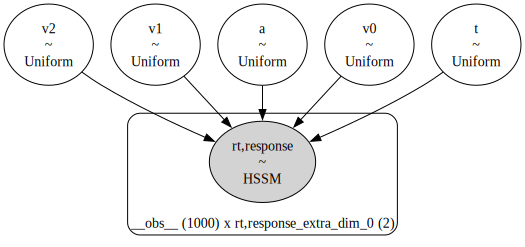

In [15]:
better_model.graph()

In [16]:
better_model_idata = better_model.sample(draws=500,
                                         tune=200,
                                         discard_tuned_samples=False)

Using default initvals. 



  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.11/site-packages/pymc/pytensorf.py:958: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(
100%|██████████| 2000/2000 [00:02<00:00, 714.09it/s]


Notice how we are back to our beloved [NUTS](https://arxiv.org/abs/1111.4246) (gradient based) sampler here! 

In [17]:
az.summary(better_model_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.481,0.066,1.366,1.611,0.003,0.002,490.0,721.0,1.00
v2,0.385,0.100,0.204,0.568,0.004,0.002,569.0,575.0,1.00
v0,1.071,0.097,0.880,1.245,0.004,0.002,677.0,974.0,1.00
v1,0.603,0.101,0.416,0.798,0.004,0.003,529.0,651.0,1.00
t,0.295,0.007,0.281,0.307,0.000,0.000,592.0,850.0,1.01


## Your Samplers are trash, I know something better!
### Help yourself!

If you don't like the samplers HSSM or even PyMC can provide out of the box, we have a remedy.
You can just compile the likelihood, and use it as a simple function downstream, however you like!

### Compiling the likelihood

In [18]:
logp_fun = better_model.compile_logp()  # msynth.pymc_model.compile_logp()
print(logp_fun(better_model.initial_point(transformed=False)))

-60571.97771234234


### Timing the compiled likelihood

In [19]:
# time
import time

my_start_point = better_model.initial_point(transformed=False)
start_time = time.time()
for i in range(1000):
    logp_fun(my_start_point)
print((time.time() - start_time) / 1000)

0.00129266095161438


### Define a simple wrapper and sample via third party library

<center> <img src="./images/zeus_sampler.png" height=300 width=600> </center>

In [20]:
def mylogp(theta: list[float]) -> float:
    """Wrap function for compiled log probability function to work with zeus sampler.

    Args
    ----
        theta: List of model parameters [v, a, z, t] where:
            v: Drift rate
            a: Boundary separation
            z: Starting point
            t: Non-decision time

    Returns
    -------
        float: Log probability value for the given parameters
    """
    v0, v1, v2, a, t = theta
    return logp_fun({"v0": v0, "v1": v1, "v2": v2, "a": a, "t": t})

In [21]:
import zeus

start = np.random.uniform(low=-0.2,
                          high=0.2,
                          size=(10, 5)) + np.tile([0.5, 1.5, 0.5, 1.5, 0.3], (10, 1)
)
sampler = zeus.EnsembleSampler(10, 5, mylogp)

In [22]:
sampler.run_mcmc(start, 1000)

Initialising ensemble of 10 walkers...
Sampling progress : 100%|██████████| 1000/1000 [01:21<00:00, 12.26it/s]


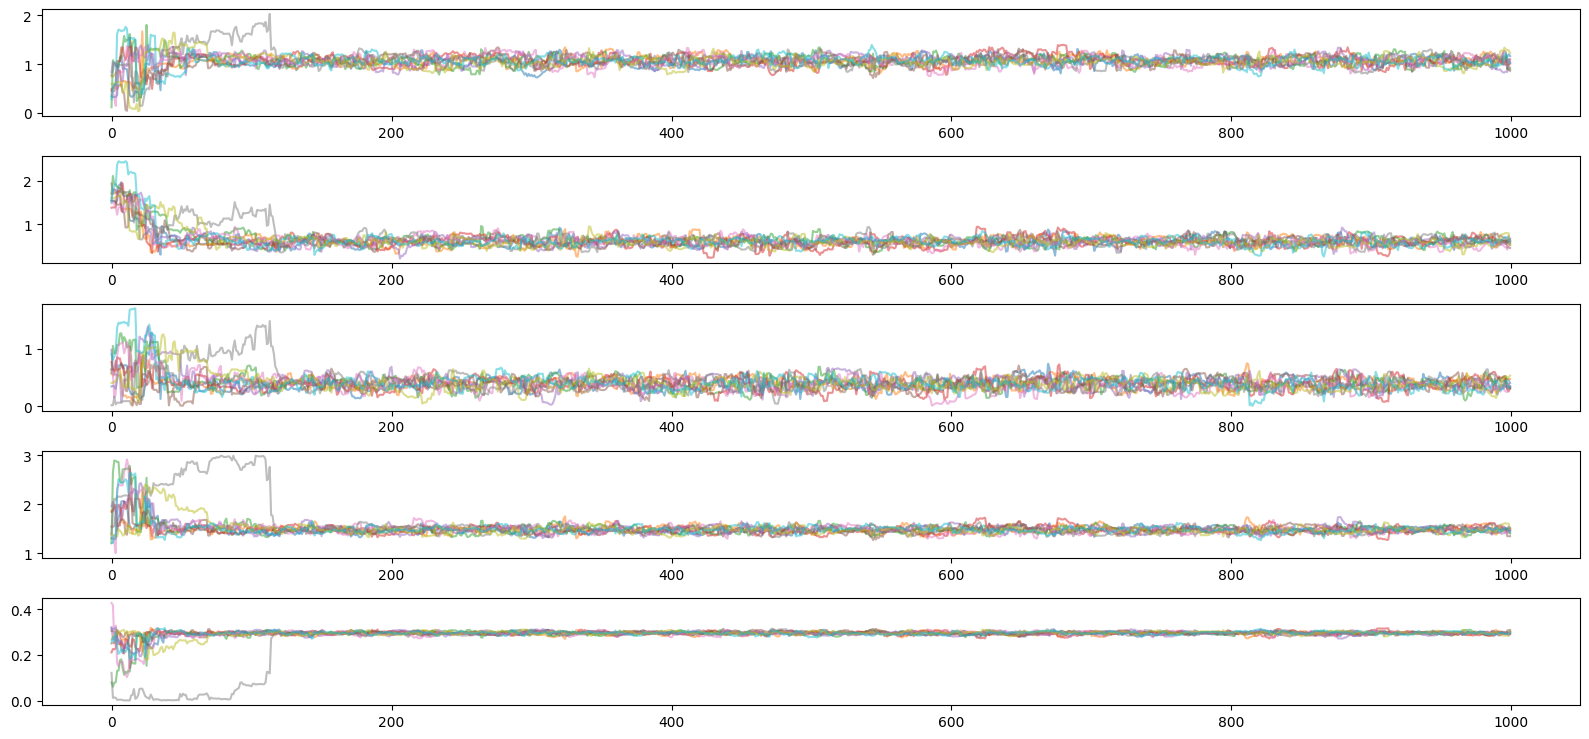

In [23]:
plt.figure(figsize=(16, 1.5 * 5))
for n in range(5):
    plt.subplot2grid((5, 1), (n, 0))
    plt.plot(sampler.get_chain()[:, :, n], alpha=0.5)
plt.tight_layout()
plt.show()

## More flexibility: We can use PyMC directly!

Now for a different degree of freedom we provide. Turns out HSSM has a few low level utilities that come in very handy for working directly with PyMC.

<center> <img src="./images/pymc_logo.png" height=300 width=600> </center>

### Basic Example: Importing pre-defined random variable

In [24]:
# DDM models (the Wiener First-Passage Time distribution)
from hssm.distribution_utils import make_distribution
from hssm.likelihoods import DDM

### Simulate synthetic data

In [25]:
# Simulate
param_dict_pymc = dict(v=0.5,
                       a=1.5,
                       z=0.5,
                       t=0.5,
                       theta=0.0)
dataset_pymc = hssm.simulate_data(model="ddm", theta=param_dict_pymc, size=1000)

In [26]:
dataset_pymc

,rt,response
0,2.173515,1.0
1,1.448614,1.0
2,4.151660,1.0
3,1.918261,-1.0
4,3.599035,1.0
...,...,...
995,1.583981,1.0
996,0.806599,1.0
997,2.073114,1.0
998,2.266149,1.0


### First PyMC Model

In [27]:
import pymc as pm

with pm.Model() as ddm_pymc:
    # Data
    obs_pt = pm.Data("obs", dataset_pymc[["rt", "response"]].values)

    # Priors
    v = pm.Uniform("v", 
                   lower=-10.0,
                   upper=10.0)
    a = pm.HalfNormal("a",
                      sigma=2.0)
    z = pm.Uniform("z",
                   lower=0.01,
                   upper=0.99)
    t = pm.Uniform("t",
                   lower=0.0,
                   upper=0.6)
    
    # Likelihood
    ddm = DDM(
        "DDM", v=v, a=a, z=z, t=t, observed=dataset_pymc[["rt", "response"]].values
    )

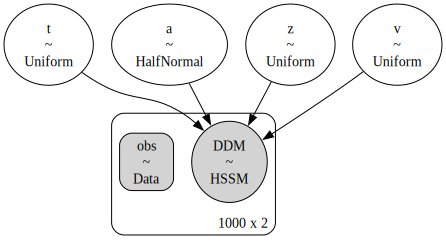

In [28]:
pm.model_to_graphviz(model=ddm_pymc)

In [29]:
with ddm_pymc:
    # Sample Posterior
    ddm_pymc_trace = pm.sample()
    # Get Posterior Predictive Samples
    pm.sample_posterior_predictive(ddm_pymc_trace,
                                   extend_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v, a, z, t]
NUTS: [v, a, z, t]
/opt/homebrew/Cellar/python@3.11/3.11.12/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/opt/homebrew/Cellar/python@3.11/3.11.12/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
Sampling: [DDM]
Sampling: [DDM]


Output()

/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/traceplot.py:218: UserWarning: A valid var_name should be provided, found {'theta'} expected from {'t', 'a', 'z', 'v'}
  warnings.warn(


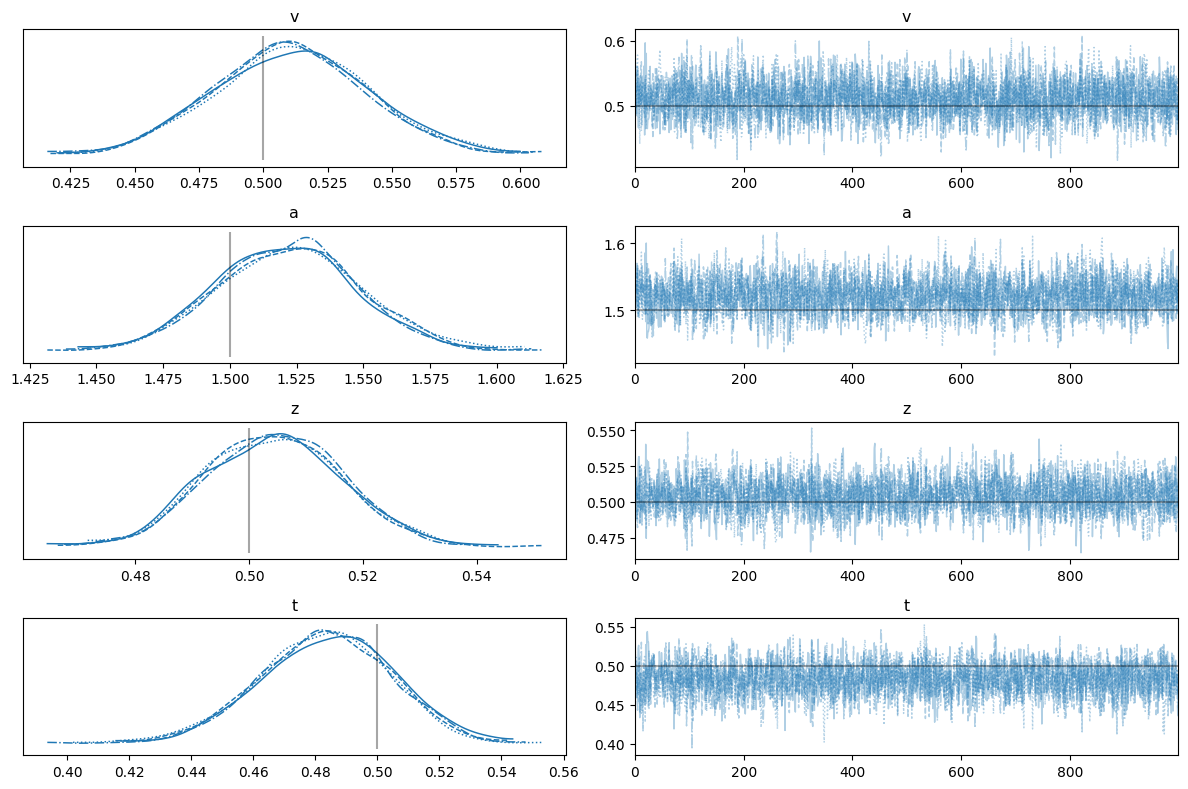

In [30]:
az.plot_trace(
    ddm_pymc_trace,
    lines=[(key_, {}, param_dict_pymc[key_]) \
           for key_ in param_dict_pymc],
)

plt.tight_layout()

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

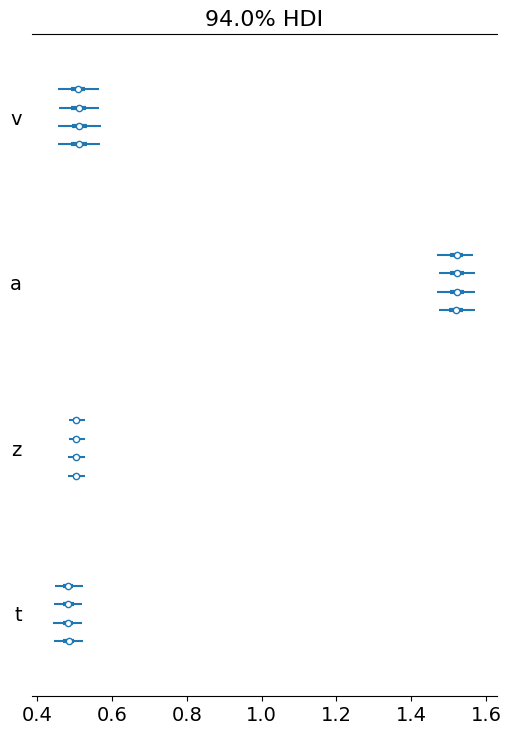

In [31]:
az.plot_forest(ddm_pymc_trace)

### Advanced Example (1): Construct your own random variable

Under the hood, a lot of the heavy lifting done by HSSM boils down to the creating of valid Random Variables that are compatible with PyMC specifications. 

In broad strokes: In probabilist programming, a minimal specification for a random variable that let's us sample all the quantities of interest for a standard Bayesian Analysis are:

- A likelihood function
- A valid simulator

If we have both of these, we can do everything. We can sample from the *posterior*, from the *prior predictive* and from the *posterior predictive*,which will cover essentially 99.9% of our needs.

Below, we use HSSM low level functionality to construct such a random variable in three simple steps. Once constructed we use it in a PyMC model natively! 

**Note**:

Truth be told, we can run MCMC without ever supplying a valid simulator and other tutorials showcase that scenario. However in such cases you are on your own once you want to sample from *posterior predictives* and/or *prior predictives*. 

In [32]:
from hssm.distribution_utils.dist import (
    make_distribution,
    make_hssm_rv,
    make_likelihood_callable,
)

# Step 1: Define a pytensor RandomVariable
CustomRV = make_hssm_rv(
    simulator_fun="race_no_bias_3",
    list_params=["v0", "v1", "v2", "a", "z", "t"]
)

# # Step 2: Define a likelihood function
logp_jax_op = make_likelihood_callable(
    loglik=network_path,
    loglik_kind="approx_differentiable",
    backend="jax",
    params_is_reg=[False, False, False, False, False, False],
    params_only=False,
)

# Step 2: Define a distribution
CustomDistribution = make_distribution(
    rv=CustomRV,
    loglik=logp_jax_op,
    list_params=["v0", "v1", "v2", "a", "z", "t"],
    bounds=dict(v0=(-3, 3), v1=(-3, 3), v2=(-3, 3), a=(0.5, 3.0), z=(0.1, 0.9), t=(0, 2.0)),
)

In [33]:
import pymc as pm

with pm.Model() as race3_pymc:
    # Data
    obs_pt = pm.Data("obs", obs_race3[["rt", "response"]].values)

    # Priors
    v0 = pm.Uniform("v0", 
                   lower=-3.0,
                   upper=3.0,
                   initval=-0.0)
    v1 = pm.Uniform("v1", 
                   lower=-3.0,
                   upper=3.0,
                   initval=0.0)
    v2 = pm.Uniform("v2", 
                   lower=-3.0,
                   upper=3.0,
                   initval=0.0)
    a = pm.HalfNormal("a",
                      sigma=2.0,
                      initval=1.0)
    z = 0.5 # We fix this parameter because it is extremely hard to jointly identify both z and a
    t = pm.Uniform("t",
                   lower=0.0,
                   upper=2.0,
                   initval=0.1)
    
    # Likelihood
    race3_obs = CustomDistribution(
        "Race3", v0=v0, v1=v1, v2=v2, a=a, z=z, t=t, observed=obs_pt
    )

In [34]:
race3_pymc

   v0 ~ Uniform(-3, 3)
   v1 ~ Uniform(-3, 3)
   v2 ~ Uniform(-3, 3)
    a ~ HalfNormal(0, 2)
    t ~ Uniform(0, 2)
Race3 ~ SSM(v0, v1, v2, a, 0.5, t)

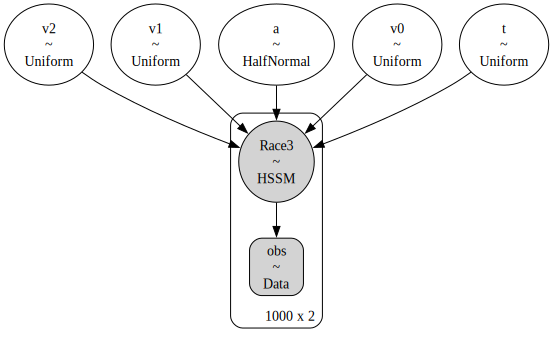

In [35]:
pm.model_to_graphviz(model=race3_pymc)

In [36]:
with race3_pymc:
    # Sample Posterior
    race3_pymc_trace = pm.sample(nuts_sampler = "numpyro",
                                 tune = 500,
                                 draws = 500)
    # Get Posterior Predictive Samples
    pm.sample_posterior_predictive(race3_pymc_trace,
                                   extend_inferencedata=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Sampling: [Race3]
Sampling: [Race3]


Output()

### Advanced Example (2): Build PyMC model that is harder to construct via HSSM directly

So far we illustrated various way of constructing random variables via HSSM utilities. The PyMC models we finally built however, 
weren't worth the manual labour... we could have let our HSSM high-level interface taken over the job.

Below we will construct a PyMC model whose properties are a bit harder (impossible) to replicate directly via HSSM.

### Simulate Data

Notice in the data simulation below: We are applying a regresion to all of `v0`, `v1`, `v2` and `a` and de facto the `beta` parameter is shared amongst all four.

In [37]:
# Simple Regression Setup
beta = 0.5
difficulty = np.random.uniform(low = -1, high = 1, size = 1000)

# Set parameters
v0 = 1.0 - beta * difficulty
v1 = 0.5 - beta * difficulty
v2 = 0.25 - beta * difficulty
a = 1.5 + beta * difficulty
t = 0.3
z = 0.5

# simulate some data from the model
obs_race3_reg = hssm.simulate_data(
    theta=dict(v0=v0, v1=v1, v2=v2, a=a, t=t, z=z), model="race_no_bias_3", size=1
)

In [38]:
obs_race3_reg

,rt,response
0,0.688401,1.0
1,0.617737,2.0
2,0.798818,1.0
3,0.507134,2.0
4,0.458191,0.0
...,...,...
995,0.576517,2.0
996,0.483258,0.0
997,0.818270,1.0
998,0.886033,0.0


In [39]:
from hssm.distribution_utils.dist import (
    make_distribution,
    make_hssm_rv,
    make_likelihood_callable,
)

# Step 1: Define a pytensor RandomVariable
CustomRV2 = make_hssm_rv(
    simulator_fun="race_no_bias_3",
    list_params=["v0", "v1", "v2", "a", "z", "t"]
)

# # Step 2: Define a likelihood function
logp_jax_op2 = make_likelihood_callable(
    loglik=network_path,
    loglik_kind="approx_differentiable",
    backend="jax",
    params_is_reg=[True, True, True, True, False, False],
    params_only=False,
)

# Step 2: Define a distribution
CustomDistribution2 = make_distribution(
    rv=CustomRV2,
    loglik=logp_jax_op2,
    list_params=["v0", "v1", "v2", "a", "z", "t"],
    bounds=dict(v0=(-3, 3), v1=(-3, 3), v2=(-3, 3), a=(0.5, 3.0), z=(0.1, 0.9), t=(0, 2.0)),
)

**Note**:

There was a subtle change to the previous version. We changes the `params_is_reg` argument from all `False` to `[True, True, True, True, False, False]`. 

Why do we do that? Because we want to construct a model that takes in `v0`, `v1`, `v2` and `a` via regressions. The likelihood therefore needs to accept these parameters as vectors, because they can vary trial-by-trial now!

### Constructing the PyMC Model

In [40]:
import pymc as pm

with pm.Model() as race3_pymc2:
    # Data
    difficulty_pt = pm.Data("difficulty", difficulty)
    obs_pt = pm.Data("obs", obs_race3_reg[["rt", "response"]].values)

    # Priors
    beta = pm.Normal("beta", mu=0, sigma=1)
    v0 = pm.Uniform("v0", 
                   lower=-3.0,
                   upper=3.0,
                   initval=-0.0)
    v1 = pm.Uniform("v1", 
                   lower=-3.0,
                   upper=3.0,
                   initval=0.0)
    v2 = pm.Uniform("v2", 
                   lower=-3.0,
                   upper=3.0,
                   initval=0.0)
    a = pm.HalfNormal("a",
                      sigma=2.0,
                      initval=1.0)
    t = pm.Uniform("t",
                   lower=0.0,
                   upper=2.0,
                   initval=0.1)
    
    z = 0.5 # We fix this parameter because it is extremely hard to jointly identify both z and a
    

    # Compute Regressions
    reg_a = pm.Deterministic("reg_a", a + beta * difficulty_pt)
    reg_v0 = pm.Deterministic("reg_v0", v0 - beta * difficulty_pt)
    reg_v1 = pm.Deterministic("reg_v1", v1 - beta * difficulty_pt)
    reg_v2 = pm.Deterministic("reg_v2", v2 - beta * difficulty_pt)

    # Likelihood
    race3_obs = CustomDistribution2(
        "Race3", v0=reg_v0, v1=reg_v1, v2=reg_v2, a=reg_a, z=z, t=t, observed= obs_pt
    )

**Note**:

Notice the construction of Deterministics. Take a look at the model graph below, the rectangular plate should seem familiar from basic HSSM graphs!
PyMC is quite flexible on that front. We can use a lot of basic math naively and it will take care of obvious broadcasting and allow us to differentiate through!

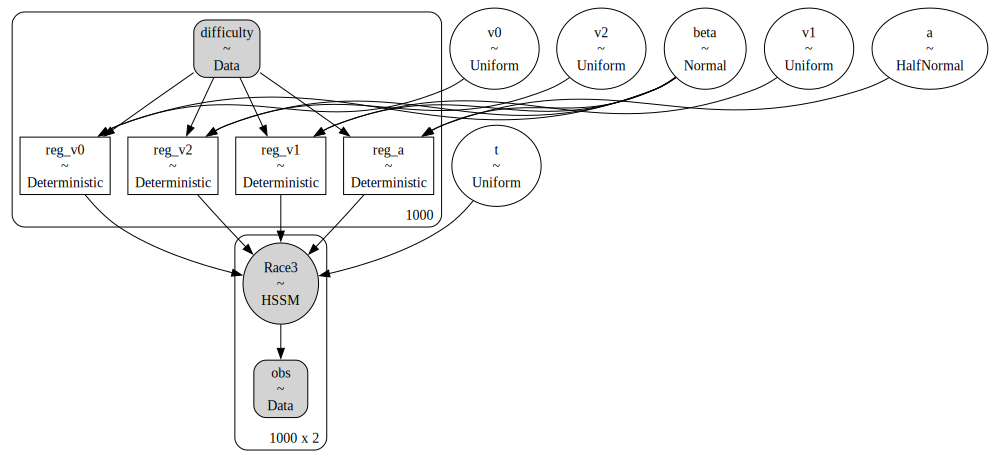

In [41]:
pm.model_to_graphviz(model=race3_pymc2)

In [42]:
with race3_pymc2:
    # Sample Posterior
    race3_pymc_trace2 = pm.sample(nuts_sampler = "numpyro",
                                  tune = 500,
                                  draws = 500)
    # Get Posterior Predictive Samples
    pm.sample_posterior_predictive(race3_pymc_trace2,
                                   extend_inferencedata=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [Race3]
Sampling: [Race3]


Output()

In [43]:
az.summary(race3_pymc_trace2, var_names = ["~reg"], filter_vars = "like")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.529,0.028,0.478,0.583,0.001,0.001,1017.0,986.0,1.00
v0,0.995,0.089,0.831,1.161,0.003,0.002,697.0,801.0,1.00
v1,0.483,0.095,0.302,0.661,0.004,0.002,706.0,978.0,1.00
v2,0.425,0.096,0.253,0.610,0.004,0.002,697.0,1149.0,1.00
a,1.445,0.056,1.343,1.549,0.002,0.002,519.0,486.0,1.01
t,0.297,0.005,0.288,0.305,0.000,0.000,660.0,677.0,1.01


## The End:

We have seen how to use introduce custom models into HSSM workflows, how to do posterior sampling with HSSM models via third party libraries and how to use the low-level functionality of HSSM to construct random variables that can be used via PyMC!

This tutorial ends here, but please feel invited to take occasion and check out more advanced topics from the HSSM docs!

## Pointers to more advanced Topics

We are scratching only the surface of what cann be done with [HSSM](https://github.com/lnccbrown/HSSM/), let alone the broader eco-system supporting [simulation based inference (SBI)](https://simulation-based-inference.org/).

Check out our simulator package, [ssm-simulators](https://github.com/lnccbrown/ssm-simulators) as well as our our little neural network library for training [LANs](https://elifesciences.org/articles/65074), [lanfactory](https://github.com/lnccbrown/LANfactory). 

Exciting work is being done (more on this in the next tutorial) on connecting to other packages in the wider eco-system, such as [BayesFlow](https://bayesflow.org/main/index.html) as well as the [sbi](https://sbi-dev.github.io/sbi/v0.24.0/) package.

Here is a taste of advanced topics with links to corresponding tutorials:

- [Variational Inference with HSSM](https://lnccbrown.github.io/HSSM/tutorials/variational_inference/)
- [Build PyMC models with HSSM random variables](https://lnccbrown.github.io/HSSM/tutorials/pymc/)
- [Connect compiled models to third party MCMC libraries](https://lnccbrown.github.io/HSSM/tutorials/compile_logp/)
- [Construct custom models from simulators and contributed likelihoods](https://lnccbrown.github.io/HSSM/tutorials/jax_callable_contribution_onnx_example/)
- [Using link functions to transform parameters](https://lnccbrown.github.io/HSSM/api/link/#hssm.Link)

you will find this and a lot more information in the [official documentation](https://lnccbrown.github.io/HSSM/)